In [63]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, BasicAer,execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator,AerSimulator
#from qiskit.providers.aer import AerSimulator
from qiskit_aer.noise import NoiseModel,thermal_relaxation_error,pauli_error,depolarizing_error
from qiskit import quantum_info as qi
from qiskit.opflow import X,Y,Z,I,PauliExpectation,StateFn,CircuitStateFn,CircuitSampler
from qiskit.utils import QuantumInstance
from random import randint
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_qasm_simulator')

In [92]:
state = QuantumCircuit(1)

#phase_shift(np.pi/4,state)
state.u(2*np.pi/4,np.pi/2,-1*np.pi/2,0)
st = CircuitStateFn(state)
#
#phase_shift
measurable_expression = StateFn(Y, is_measurement=True).compose(st)

# define your backend or quantum instance (where you can add settings)
backend = Aer.get_backend('qasm_simulator') 
q_instance = QuantumInstance(backend, shots=1024)

# define the state to sample
measurable_expression = StateFn(X, is_measurement=True).compose(st) 

# convert to expectation value
expectation = PauliExpectation().convert(measurable_expression)  

# get state sampler (you can also pass the backend directly)
sampler = CircuitSampler(q_instance).convert(expectation) 

# evaluate
print('Sampled:', sampler.eval().real)

Sampled: -0.035156249999999944


In [98]:
def Cont():
    A = randint(0,1)
    qc2 = QuantumCircuit(1,1)
    qc2.reset(0)
    if A == 1:
        qc2.x(0)
    return qc2
tau = 2
prop= 0.1
p_meas = 0.1
error2 = depolarizing_error(prop, 1)
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
ntot =30
average = 100
angle = np.pi/ntot*8
L3 = []
Ltot = []
qc1 = QuantumCircuit(1)
for j in range(average):
    L=[]
    L2 = []
    for n in range(ntot):
        qc1 = Cont()
        for i in range(n):
            qc1.u(angle,np.pi/2,-np.pi/2,0)
        qc1.measure(0,0)
        #qc2 = meas.compose(qc1, range(1), front=True)
        error = thermal_relaxation_error(tau,tau,n/ntot)
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(error, ['u'])
        noise_model.add_all_qubit_quantum_error(error2, ['u'])
        noise_model.add_all_qubit_quantum_error(error_meas, "measure") 
        basis_gates = noise_model.basis_gates

        res = execute(qc1, AerSimulator(),shots=1,basis_gates=basis_gates,noise_model=noise_model).result()
        L.append(res.get_counts(qc1))
        if '0' in L[n]:
            nup = L[n]['0']/average
        else:
            nup = 0
        if '1' in L[n]:
            ndown = L[n]['1']/average
        else:
            ndown = 0

        L2.append(nup-ndown)
    L3.append(L2)
for n in range(ntot):
    w=0
    for k in range(average):
        w = w + L3[k][n]
    Ltot.append(w)

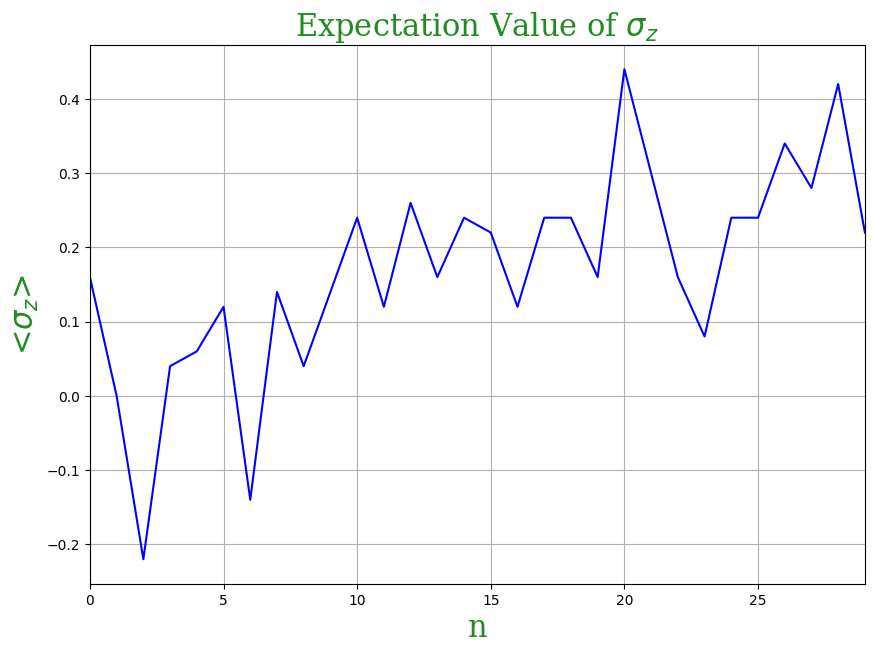

In [100]:
plot_expectation_value(range(30),Ltot, ylabel='$\sigma_z$',x_range=[0,n],xlabel = 'n')

In [2]:
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
backend = AerSimulator()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import numpy.linalg as linalg
import scipy
from scipy.linalg import expm , cosm, sinm
style.use('seaborn-v0_8-bright')

In [4]:

font = {'family': 'serif',
    'color':  'forestgreen',
    'weight': 'normal',
    'size': 22,
    }

    

def plot_expectation_value(x,y,ylabel,xlabel = '$\omega$t',fig_size=(10.0,7.0),plot_grid=True,x_range=[0,8*np.pi],colour='b'):
    plt.figure(figsize = fig_size)
    plt.plot(x,y,colour)
    plt.xlim(x_range)
    plt.grid(plot_grid)
    plt.xlabel(xlabel, fontdict=font)
    plt.ylabel('<'+ylabel+'>', fontdict=font)
    plt.title(f'Expectation Value of {ylabel}',fontdict=font)

In [156]:
qc = QuantumCircuit(1,1)
#phase_shift(np.pi/4,qc)
#phase_shift(np.pi/4,qc)

def phase_shift_X(angle,state):
    return state.u(2*angle,np.pi/2,-1*np.pi/2,0)

def phase_shift_Y(angle,state):
    return state.u(2*angle,np.pi,-1*np.pi,0)

def phase_shift_Z(angle,state):
    return state.u(2*angle,np.pi,-1*np.pi,0)


def apply_unitary(expect,state):
    if expect == 'sigma_X':
        return state.u(np.pi/2,np.pi,-1*np.pi,0)
    elif expect == 'sigma_Y':
        return state.u(3*np.pi/2,np.pi/2,-1*np.pi/2,0)
    elif expect == 'sigma_Z':
        return state

def phase_shift_loop(n,angle,init_state,expect,shots,backend,noise_flag,tau=0.6,p_meas=0.01):
    '''this will run the phase shift n times. Will then execute for the number of shots provided'''
    #state = QuantumCircuit(1,1)
    #state.reset(0)
    state = init_state()
    #state = init_qubit(1,0)
    L= []
    for i in range(1,n):
        phase_shift_X(angle,state)
    apply_unitary(expect,state)
    
    state.measure(0,0)
    error = thermal_relaxation_error(tau,tau,n/shots)
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['u'])
    #noise_model.add_all_qubit_quantum_error(error, ['u'])
    #noise_model.add_all_qubit_quantum_error(error2, ['u'])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    #else:
    #noise_model = noise.NoiseModel.from_backend(provider.get_backend('ibmq_lima'))
    basis_gates = noise_model.basis_gates
    #b = BasicAer.get_backend('qasm_simulator')
    #job_simulator = execute(qc, b, shots)
    coupling_map = backend.configuration().coupling_map
    #qc = QuantumCircuit(1,1)
    #phase_shift(angle,qc)
    #qc.measure(0,0)
# Get basis gates from noise model
    #basis_gates = noise_model.basis_gates
    #error = noise.thermal_relaxation_error(tau,tau,n/shots)
    #noise_model.add_all_qubit_quantum_error(error, ['u'])
    if noise_flag:
        job_simulator = execute(state, backend,shots=shots,coupling_map=coupling_map,basis_gates=basis_gates,noise_model=noise_model)
    else:
        #print('here')
        job_simulator = execute(state, backend, shots=shots)
    #print(len(job_simulator))
    #job_simulator = execute(state, backend,shots=shots,coupling_map=coupling_map,basis_gates=basis_gates,noise_model=noise_model)
    result_simulator = job_simulator.result()
    L.append(result_simulator.get_counts(state))
    return L



def phase_shift_loop_master(angle,n,init_state,expect,shots,backend,noise_flag):
    '''this will run the phase loop for each n'''
    results = []
    for i in range(1,n):
        #state = QuantumCircuit(1,1)
        r = phase_shift_loop(i,angle,init_state,expect,shots,backend,noise_flag)
        #print(r)
        r0 = r[0]
        n_up = (1*r[0]['0']) if '0' in r0.keys() else 0
        n_down = (-1*r[0]['1']) if '1' in r0.keys() else 0
        results.append(((n_up+n_down)/shots))
        #print(results)
    return results

#print(counts)
#x = []
#for i in range(1,1000):
#phase_shift_loop_master(np.pi/100,100,1000,QuantumCircuit(1,1))



def my_plot(angle,n,init_state,expect,shots = 1000,backend=backend, noise_flag=False):
    '''function to plot my phase shift results i.e. expecatation value of sigma z over time'''
    results = phase_shift_loop_master(angle,n,init_state,expect,shots,backend,noise_flag)
    plot_expectation_value(range(1,n),results, ylabel='$\sigma_z$',x_range=[0,n],xlabel = 'n')


def init_qubit(x,y):
    res = QuantumCircuit(1,1)
    res.initialize([x,y],res.qubits)
    return res

def init_Z():
    return init_qubit(1,0)

def init_Y():
    return init_qubit(1/np.sqrt(2), 1j*1/np.sqrt(2))

def init_X():
    return init_qubit(1/np.sqrt(2), 1/np.sqrt(2))

#init_X = init_qubit(1/np.sqrt(2), 1/np.sqrt(2))
#init_Y = init_qubit(1/np.sqrt(2), 1j*1/np.sqrt(2))
#init_Z = init_qubit(1,0)

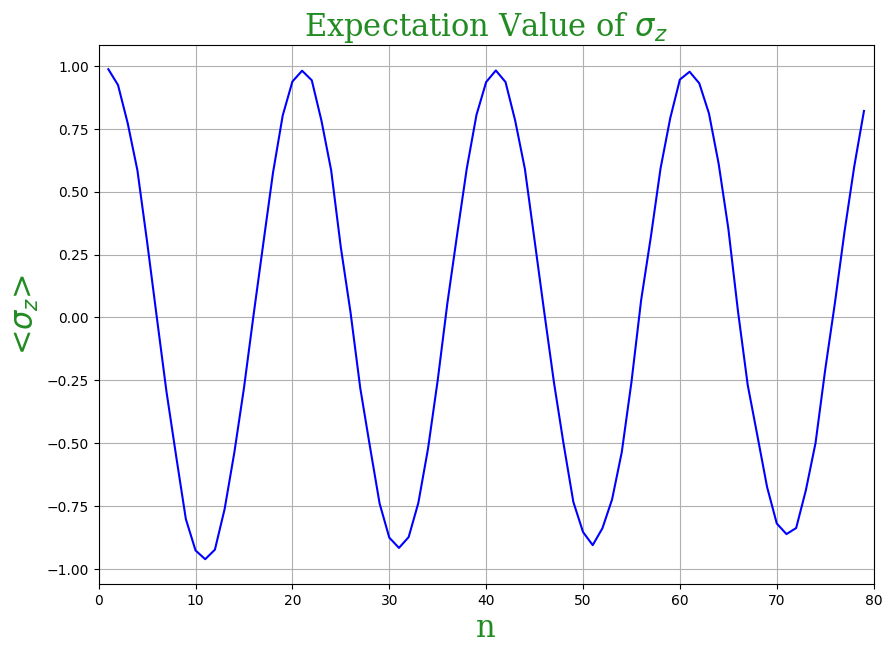

In [159]:
#backend = AerSimulator()
#state = QuantumCircuit(1,1)
my_plot(np.pi/20,80,init_Z,'sigma_Z',shots = 2000,backend=backend,noise_flag=True)

In [114]:
my_plot(np.pi/10,20,init_X,shots = 100,backend=backend,noise_flag=False)

TypeError: my_plot() missing 1 required positional argument: 'expect'

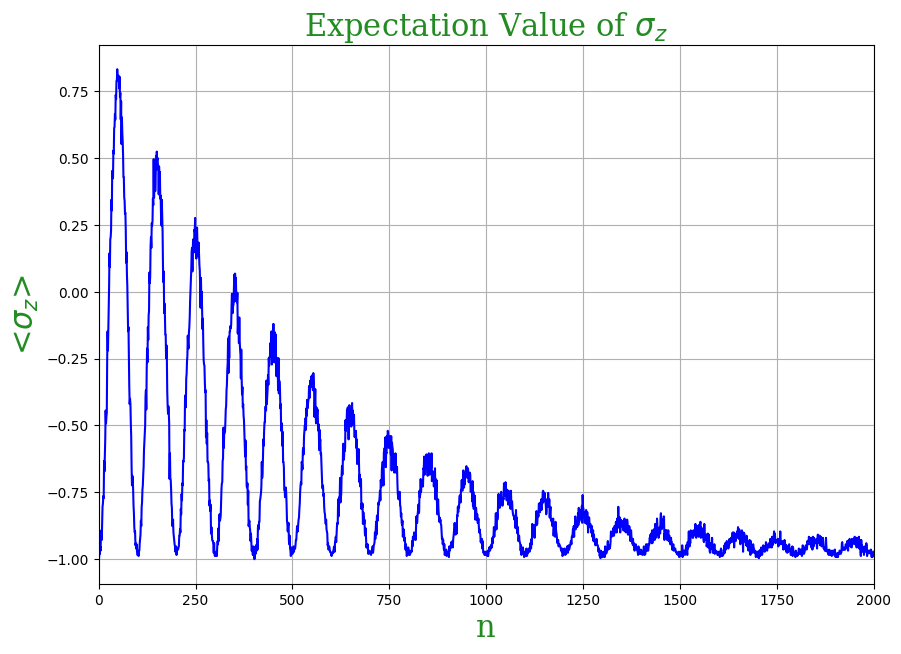

In [42]:
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = AerSimulator()
my_plot(np.pi/100,2000,shots = 500,backend=backend,noise_flag=True)

In [45]:
backend = AerSimulator()
my_plot(np.pi/10,30,init_Z,shots = 50,backend=backend,noise_flag=True)

KeyboardInterrupt: 

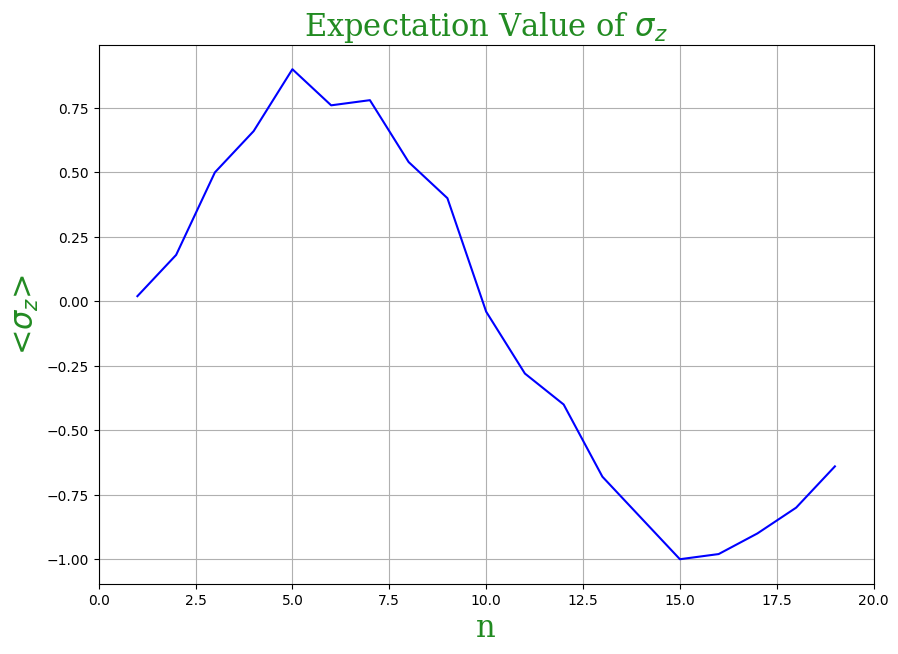

In [39]:
my_plot(np.pi/20,20,init_Y,shots = 100,backend=backend,noise_flag=True)

In [180]:
qc = QuantumCircuit(1)
qc.initialize([1/np.sqrt(2), 1/np.sqrt(2)],qc.qubits)
qi.DensityMatrix.from_instruction(qc)

DensityMatrix([[0.5+0.j, 0.5+0.j],
               [0.5+0.j, 0.5+0.j]],
              dims=(2,))


In [210]:
def init_qubit(x,y):
    circ = QuantumCircuit(1)
    qc.initialize([x,y],qc.qubits)
    return qc

init_X = init_qubit(1/np.sqrt(2), 1/np.sqrt(2))
init_Y = init_qubit(1/np.sqrt(2), 1j*1/np.sqrt(2))
init_Z = init_qubit(1,0)

In [212]:
init_X = init_qubit(1/np.sqrt(2), 1/np.sqrt(2))
init_Y = init_qubit(1/np.sqrt(2), 1j*1/np.sqrt(2))
init_Z = init_qubit(1,0)



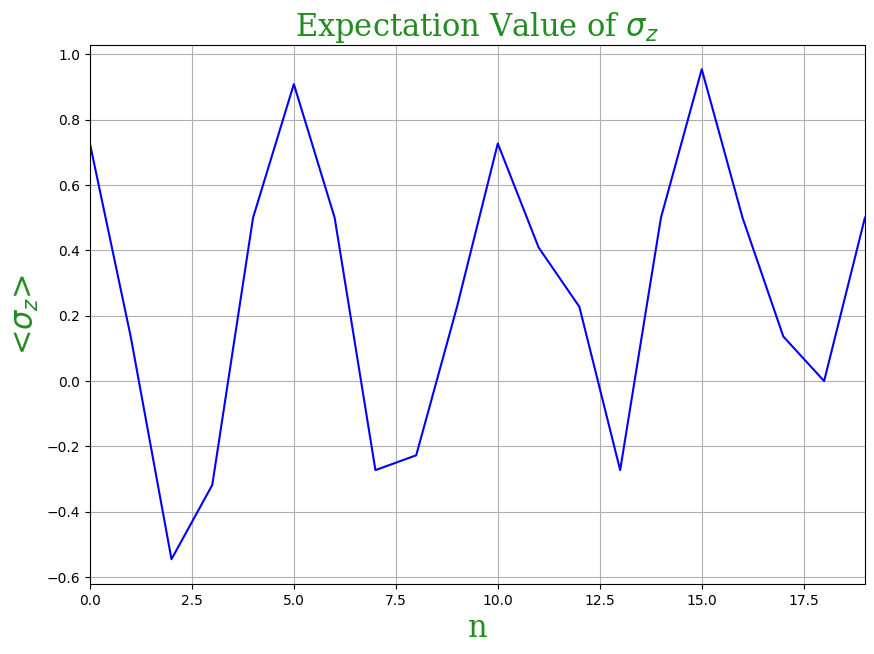

In [230]:
meas = QuantumCircuit(1,1)
meas.barrier(range(1))
meas.measure(range(1),range(1))
backend = AerSimulator()
tau = 2
prop= 0.1
p_meas = 0.1
error2 = noise.depolarizing_error(prop, 1)
error_meas = noise.pauli_error([('X',p_meas), ('I', 1 - p_meas)])
ntot =20
average = 44
L=[]
L2 = []
#error = noise.thermal_relaxation_error(tau,tau,n/ntot)
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error, ['u'])
#noise_model.add_all_qubit_quantum_error(error2, ['u'])
#noise_model.add_all_qubit_quantum_error(error_meas, "measure") 
#basis_gates = noise_model.basis_gates
#qc1 = QuantumCircuit(1)
for n in range(ntot):
    qc1 = QuantumCircuit(1)
    angle = np.pi/ntot*8
    for i in range(n):
        qc1.u(angle,np.pi/2,-np.pi/2,0)
    qc2 = meas.compose(qc1, range(1), front=True)
    error = noise.thermal_relaxation_error(tau,tau,n/ntot)
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['u'])
    #noise_model.add_all_qubit_quantum_error(error, ['u'])
    #noise_model.add_all_qubit_quantum_error(error2, ['u'])
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") 
    basis_gates = noise_model.basis_gates

    res = execute(qc2, Aer.get_backend('qasm_simulator'),shots=average,basis_gates=basis_gates,noise_model=noise_model).result()
    L.append(res.get_counts(qc2))
    if '0' in L[n]:
        nup = L[n]['0']/average
    else:
        nup = 0
    if '1' in L[n]:
        ndown = L[n]['1']/average
    else:
        ndown = 0

    L2.append(nup-ndown)
plot_expectation_value(range(20),L2, ylabel='$\sigma_z$',x_range=[0,n],xlabel = 'n')

In [195]:
qc = QuantumCircuit(1,1)
qc.h(0)
phase_shift(np.pi/4,qc)
x = qi.DensityMatrix.from_instruction(qc)
qi.DensityMatrix.purity(x)

(1+5.551115123125783e-17j)

In [208]:
qc = QuantumCircuit(1,1)
I = qi.Operator.from_label('I')
#qc.evolve(I)
x = qi.DensityMatrix.from_instruction(qc)
x.evolve(I)
x

DensityMatrix([[1.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j]],
              dims=(2,))


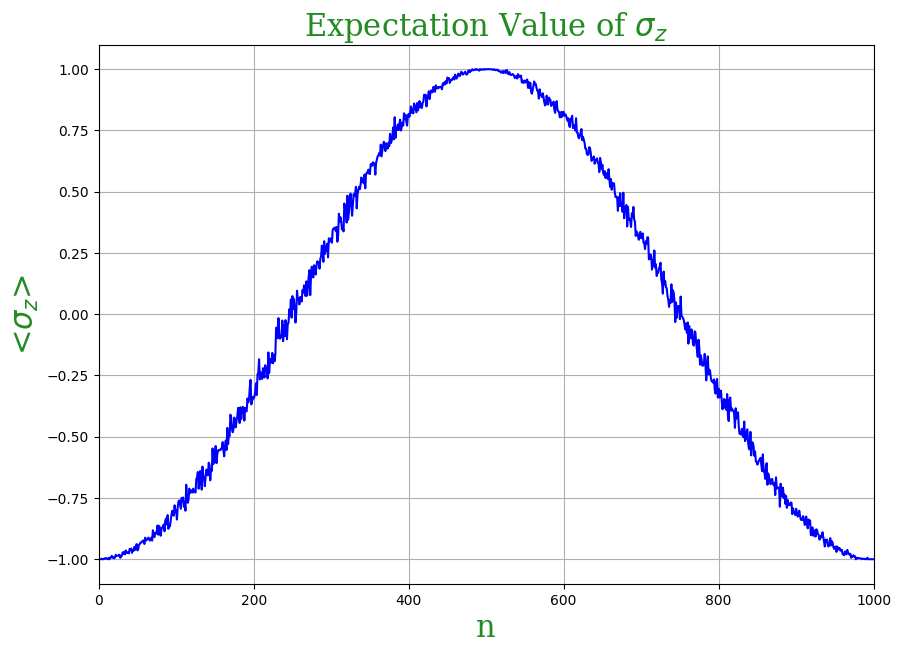

In [298]:
def phase_shift(angle,state):
    return state.u(2*angle,np.pi/2,-1*np.pi/2,0)

plot_expectation_value(range(1,1000),x, ylabel='$\sigma_z$',x_range=[0,1000],xlabel = 'n')

In [183]:
import inspect
print(inspect.getsource(phase_shift))

def phase_shift(angle,state):
    return state.u(2*angle,np.pi/2,-1*np.pi/2,0)



In [175]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ModuleNotFoundError: No module named 'ipywidgets'

In [210]:
from qiskit.providers.aer import AerSimulator
backend = AerSimulator()

In [187]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [174]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ